In [1]:
#Important data Collection Libraries
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

### Separable Convolutions - FCN Layers

In [3]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
It is used in the decoder block of FCN. Upsampling by a factor 2. The "utils.separable_conv2d" folder contains the implementation of customized form of Keras UpSampling2D named BilinearUpSampling2D.

In [4]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Building the Model 

### Encoder Block

In [5]:
#the 'filters' parameter defines the size or depth of the output layer
def encoder_block(input_layer, filters, strides):
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block

In [6]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsample = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenate_upsample = layers.concatenate([upsample,large_ip_layer])
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concatenate_upsample,filters,1)
    output_layer = separable_conv2d_batchnorm(output_layer,filters,1)
    return output_layer

### FCN Architecture

In [7]:
def fcn_model(inputs, num_classes):
    
    # Add Encoder Blocks. 
    filter = 96
    encoder_one = encoder_block(inputs,filter,2)
    encoder_two = encoder_block(encoder_one,filter *2, 2)
    encoder_three = encoder_block(encoder_two,filter*4,2)
    
    # Add 1x1 Convolution layer using conv2d_batchnorm().
    one_to_one_convolution = conv2d_batchnorm(encoder_three,filter*4,kernel_size=1,strides =1)
    
    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_three = decoder_block(one_to_one_convolution,encoder_two,filter *4)
    decoder_two = decoder_block(decoder_three,encoder_one,filter *2)
    decoder_one = decoder_block(decoder_two,inputs,filter)
    
    
    # Returns the output layer of your model
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(decoder_one)

In [8]:
#utils.data_iterator.py will resize the copter images to 160x160x3to speed up training
image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3
output_layer = fcn_model(inputs, num_classes)

In [9]:
learning_rate = 0.01
batch_size = 15
num_epochs = 60
steps_per_epoch = 200     #number of batches of training images that go through the network in 1 epoch
validation_steps = 50    #number of batches of validation images for 1 epoch
workers = 2   #maximum number oof processes to spin up

Epoch 1/60
199/200 [============================>.] - ETA: 0s - loss: 0.1524

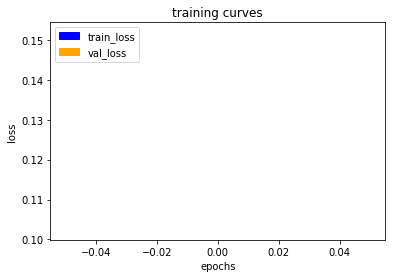

200/200 [==============================] - 103s - loss: 0.1519 - val_loss: 0.1024
Epoch 2/60
199/200 [============================>.] - ETA: 0s - loss: 0.0542

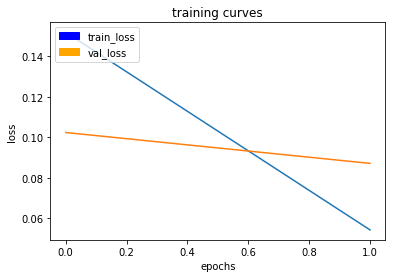

200/200 [==============================] - 97s - loss: 0.0542 - val_loss: 0.0871
Epoch 3/60
199/200 [============================>.] - ETA: 0s - loss: 0.0460

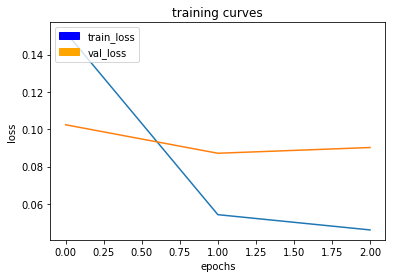

200/200 [==============================] - 97s - loss: 0.0460 - val_loss: 0.0902
Epoch 4/60
199/200 [============================>.] - ETA: 0s - loss: 0.0389

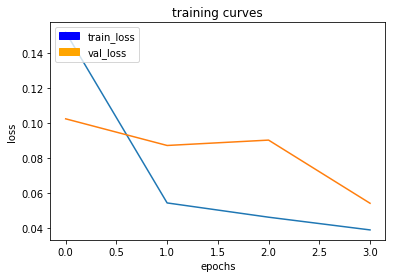

200/200 [==============================] - 97s - loss: 0.0388 - val_loss: 0.0541
Epoch 5/60
199/200 [============================>.] - ETA: 0s - loss: 0.0365

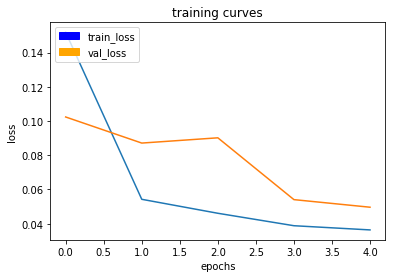

200/200 [==============================] - 97s - loss: 0.0364 - val_loss: 0.0496
Epoch 6/60
199/200 [============================>.] - ETA: 0s - loss: 0.0440

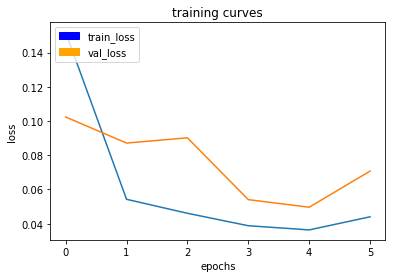

200/200 [==============================] - 97s - loss: 0.0440 - val_loss: 0.0707
Epoch 7/60
199/200 [============================>.] - ETA: 0s - loss: 0.0364

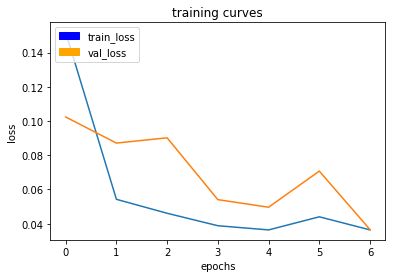

200/200 [==============================] - 97s - loss: 0.0364 - val_loss: 0.0365
Epoch 8/60
199/200 [============================>.] - ETA: 0s - loss: 0.0330

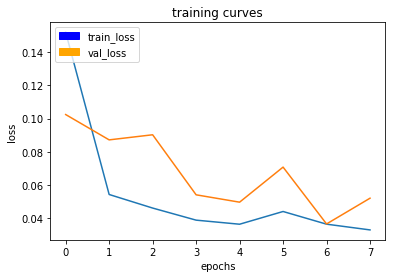

200/200 [==============================] - 97s - loss: 0.0329 - val_loss: 0.0520
Epoch 9/60
199/200 [============================>.] - ETA: 0s - loss: 0.0340

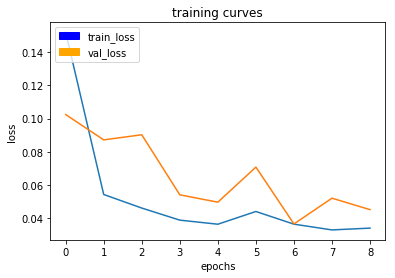

200/200 [==============================] - 97s - loss: 0.0340 - val_loss: 0.0451
Epoch 10/60
199/200 [============================>.] - ETA: 0s - loss: 0.0316

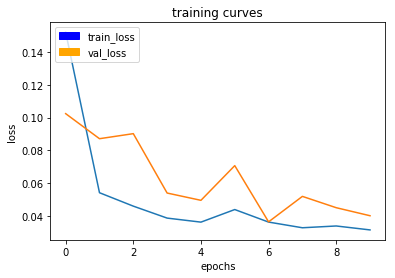

200/200 [==============================] - 97s - loss: 0.0316 - val_loss: 0.0403
Epoch 11/60
199/200 [============================>.] - ETA: 0s - loss: 0.0313

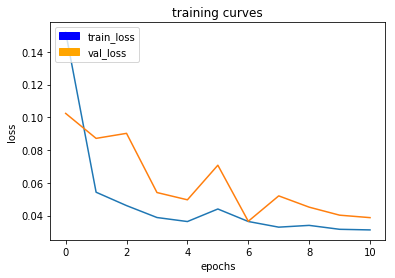

200/200 [==============================] - 98s - loss: 0.0313 - val_loss: 0.0387
Epoch 12/60
199/200 [============================>.] - ETA: 0s - loss: 0.0293

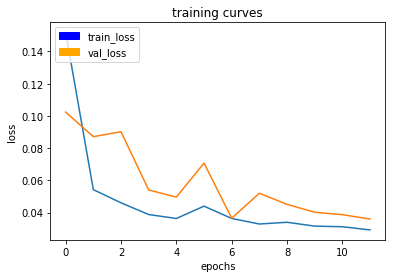

200/200 [==============================] - 96s - loss: 0.0293 - val_loss: 0.0360
Epoch 13/60
199/200 [============================>.] - ETA: 0s - loss: 0.0262

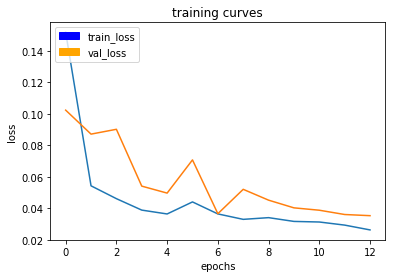

200/200 [==============================] - 97s - loss: 0.0262 - val_loss: 0.0353
Epoch 14/60
199/200 [============================>.] - ETA: 0s - loss: 0.0298

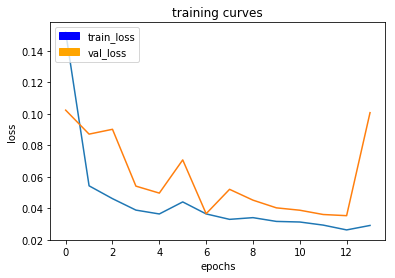

200/200 [==============================] - 97s - loss: 0.0297 - val_loss: 0.1008
Epoch 15/60
199/200 [============================>.] - ETA: 0s - loss: 0.0292

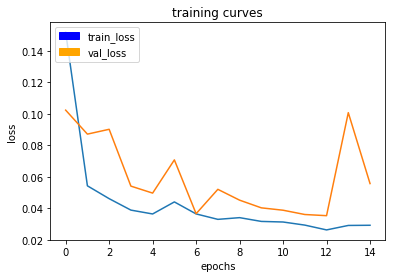

200/200 [==============================] - 97s - loss: 0.0292 - val_loss: 0.0557
Epoch 16/60
199/200 [============================>.] - ETA: 0s - loss: 0.0246

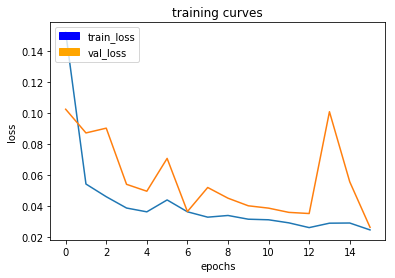

200/200 [==============================] - 97s - loss: 0.0248 - val_loss: 0.0264
Epoch 17/60
199/200 [============================>.] - ETA: 0s - loss: 0.0233

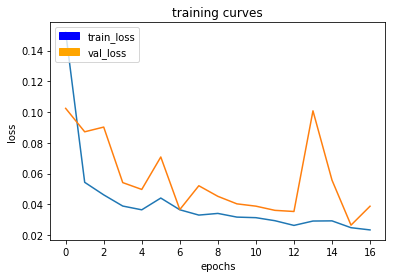

200/200 [==============================] - 97s - loss: 0.0233 - val_loss: 0.0387
Epoch 18/60
199/200 [============================>.] - ETA: 0s - loss: 0.0267

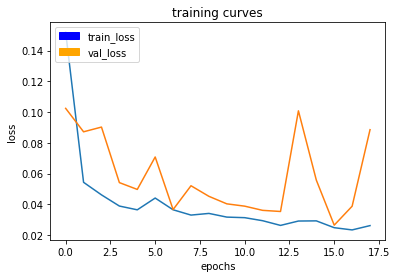

200/200 [==============================] - 97s - loss: 0.0267 - val_loss: 0.0885
Epoch 19/60
199/200 [============================>.] - ETA: 0s - loss: 0.0240

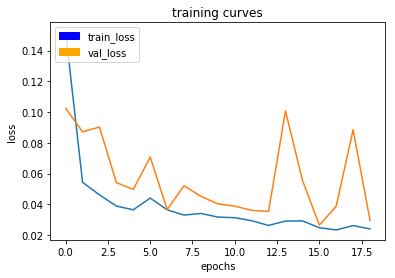

200/200 [==============================] - 97s - loss: 0.0240 - val_loss: 0.0294
Epoch 20/60
199/200 [============================>.] - ETA: 0s - loss: 0.0236

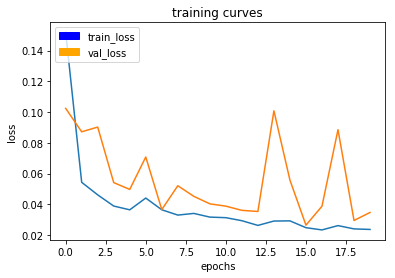

200/200 [==============================] - 97s - loss: 0.0236 - val_loss: 0.0346
Epoch 21/60
199/200 [============================>.] - ETA: 0s - loss: 0.0202

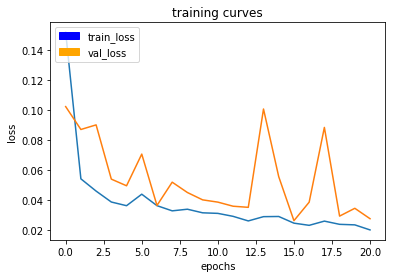

200/200 [==============================] - 97s - loss: 0.0202 - val_loss: 0.0277
Epoch 22/60
199/200 [============================>.] - ETA: 0s - loss: 0.0233

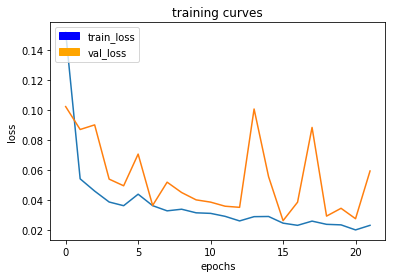

200/200 [==============================] - 97s - loss: 0.0233 - val_loss: 0.0595
Epoch 23/60
199/200 [============================>.] - ETA: 0s - loss: 0.0204

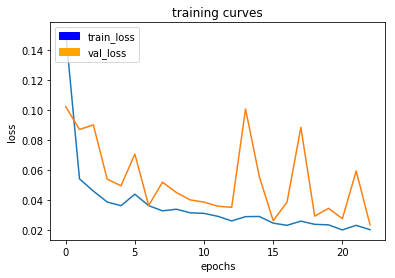

200/200 [==============================] - 97s - loss: 0.0204 - val_loss: 0.0237
Epoch 24/60
199/200 [============================>.] - ETA: 0s - loss: 0.0236

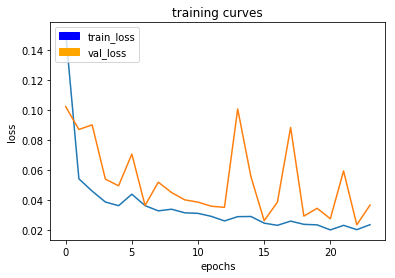

200/200 [==============================] - 96s - loss: 0.0237 - val_loss: 0.0368
Epoch 25/60
199/200 [============================>.] - ETA: 0s - loss: 0.0222

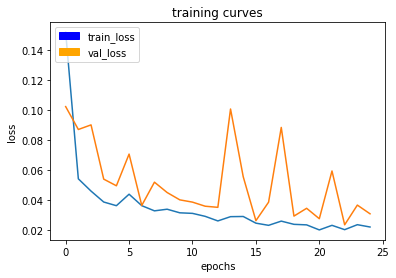

200/200 [==============================] - 97s - loss: 0.0221 - val_loss: 0.0310
Epoch 26/60
199/200 [============================>.] - ETA: 0s - loss: 0.0188

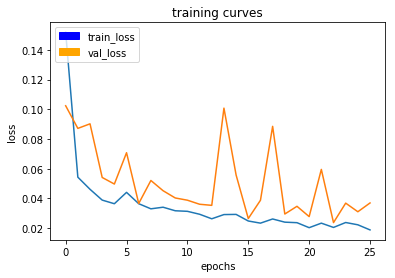

200/200 [==============================] - 97s - loss: 0.0187 - val_loss: 0.0369
Epoch 27/60
199/200 [============================>.] - ETA: 0s - loss: 0.0192

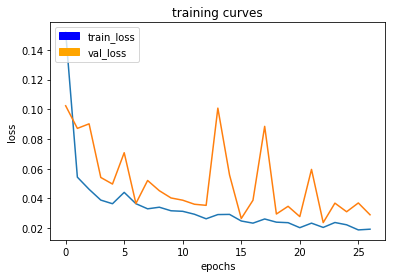

200/200 [==============================] - 97s - loss: 0.0192 - val_loss: 0.0289
Epoch 28/60
199/200 [============================>.] - ETA: 0s - loss: 0.0175

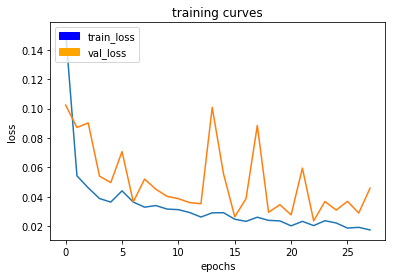

200/200 [==============================] - 97s - loss: 0.0175 - val_loss: 0.0459
Epoch 29/60
199/200 [============================>.] - ETA: 0s - loss: 0.0197

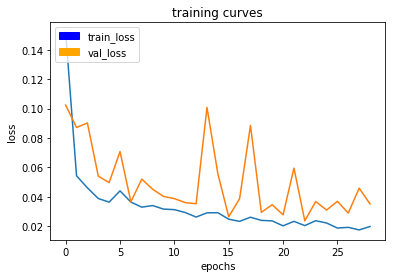

200/200 [==============================] - 96s - loss: 0.0198 - val_loss: 0.0351
Epoch 30/60
199/200 [============================>.] - ETA: 0s - loss: 0.0182

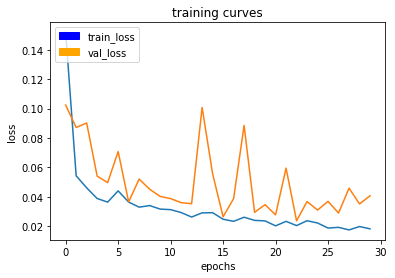

200/200 [==============================] - 98s - loss: 0.0182 - val_loss: 0.0407
Epoch 31/60
199/200 [============================>.] - ETA: 0s - loss: 0.0177

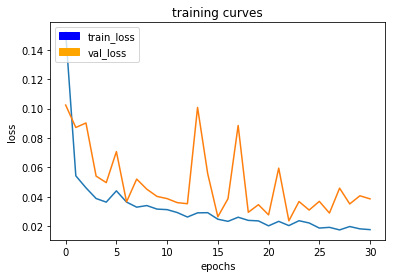

200/200 [==============================] - 97s - loss: 0.0176 - val_loss: 0.0386
Epoch 32/60
199/200 [============================>.] - ETA: 0s - loss: 0.0144

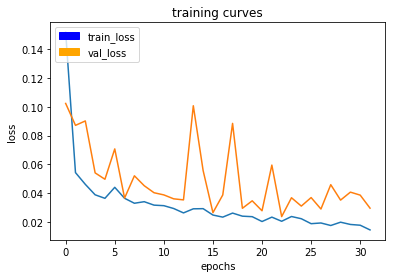

200/200 [==============================] - 97s - loss: 0.0144 - val_loss: 0.0295
Epoch 33/60
199/200 [============================>.] - ETA: 0s - loss: 0.0166

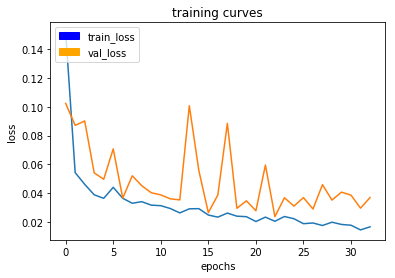

200/200 [==============================] - 97s - loss: 0.0165 - val_loss: 0.0369
Epoch 34/60
199/200 [============================>.] - ETA: 0s - loss: 0.0199

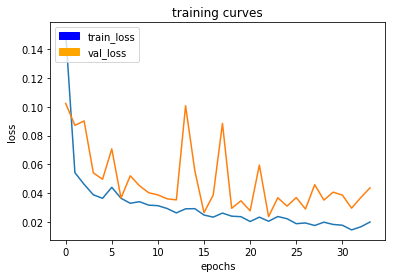

200/200 [==============================] - 97s - loss: 0.0199 - val_loss: 0.0437
Epoch 35/60
199/200 [============================>.] - ETA: 0s - loss: 0.0151

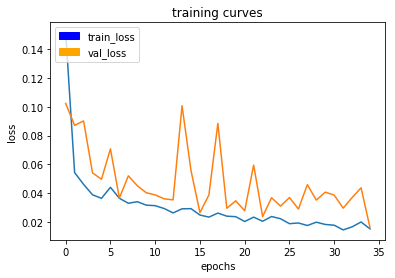

200/200 [==============================] - 97s - loss: 0.0151 - val_loss: 0.0159
Epoch 36/60
199/200 [============================>.] - ETA: 0s - loss: 0.0160

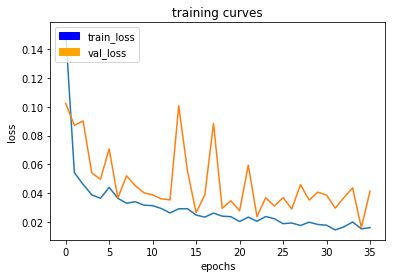

200/200 [==============================] - 97s - loss: 0.0160 - val_loss: 0.0414
Epoch 37/60
199/200 [============================>.] - ETA: 0s - loss: 0.0167

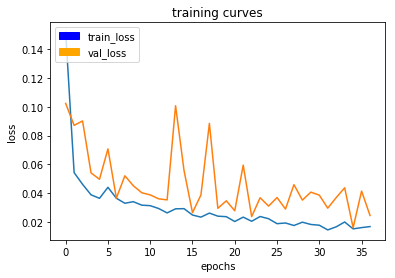

200/200 [==============================] - 97s - loss: 0.0167 - val_loss: 0.0244
Epoch 38/60
199/200 [============================>.] - ETA: 0s - loss: 0.0201

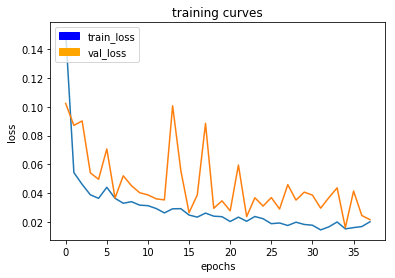

200/200 [==============================] - 98s - loss: 0.0200 - val_loss: 0.0215
Epoch 39/60
199/200 [============================>.] - ETA: 0s - loss: 0.0157

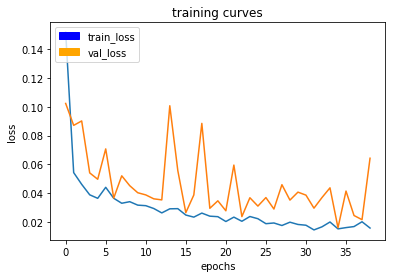

200/200 [==============================] - 97s - loss: 0.0157 - val_loss: 0.0643
Epoch 40/60
199/200 [============================>.] - ETA: 0s - loss: 0.0147

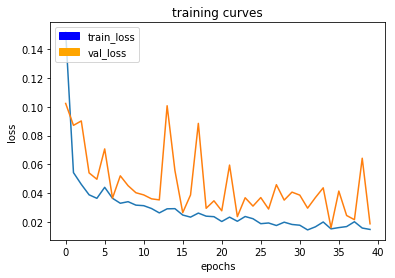

200/200 [==============================] - 95s - loss: 0.0147 - val_loss: 0.0186
Epoch 41/60
199/200 [============================>.] - ETA: 0s - loss: 0.0162

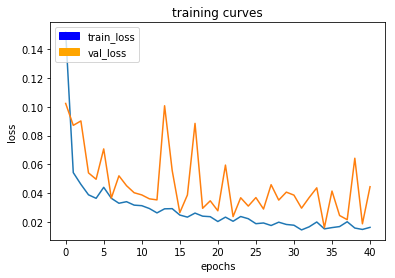

200/200 [==============================] - 95s - loss: 0.0162 - val_loss: 0.0444
Epoch 42/60
199/200 [============================>.] - ETA: 0s - loss: 0.0135

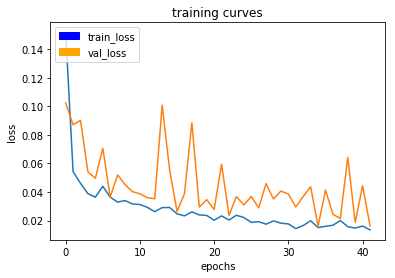

200/200 [==============================] - 95s - loss: 0.0134 - val_loss: 0.0163
Epoch 43/60
199/200 [============================>.] - ETA: 0s - loss: 0.0114

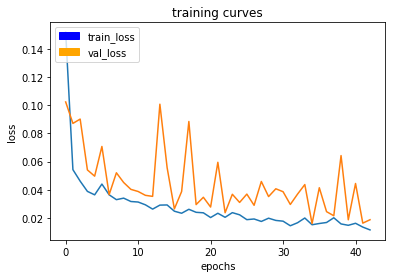

200/200 [==============================] - 95s - loss: 0.0114 - val_loss: 0.0187
Epoch 44/60
199/200 [============================>.] - ETA: 0s - loss: 0.0143

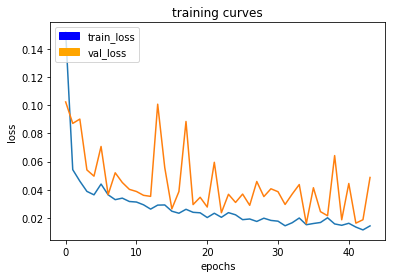

200/200 [==============================] - 95s - loss: 0.0143 - val_loss: 0.0487
Epoch 45/60
199/200 [============================>.] - ETA: 0s - loss: 0.0175

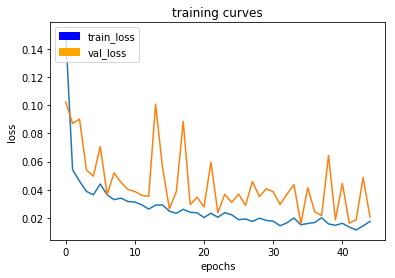

200/200 [==============================] - 95s - loss: 0.0175 - val_loss: 0.0206
Epoch 46/60
199/200 [============================>.] - ETA: 0s - loss: 0.0142

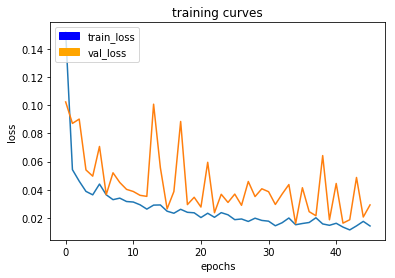

200/200 [==============================] - 95s - loss: 0.0142 - val_loss: 0.0292
Epoch 47/60
199/200 [============================>.] - ETA: 0s - loss: 0.0133

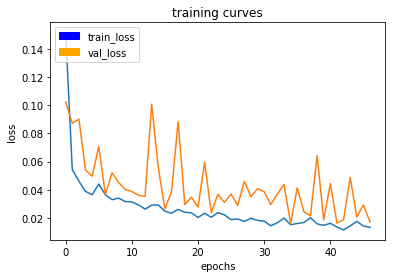

200/200 [==============================] - 95s - loss: 0.0133 - val_loss: 0.0170
Epoch 48/60
199/200 [============================>.] - ETA: 0s - loss: 0.0122

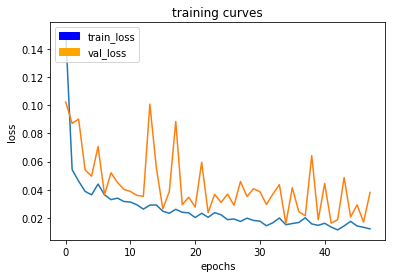

200/200 [==============================] - 95s - loss: 0.0122 - val_loss: 0.0380
Epoch 49/60
199/200 [============================>.] - ETA: 0s - loss: 0.0155

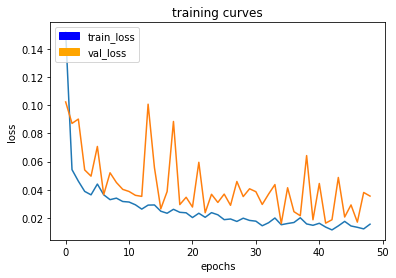

200/200 [==============================] - 95s - loss: 0.0155 - val_loss: 0.0355
Epoch 50/60
199/200 [============================>.] - ETA: 0s - loss: 0.0142

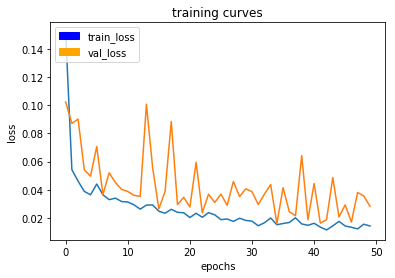

200/200 [==============================] - 94s - loss: 0.0142 - val_loss: 0.0282
Epoch 51/60
199/200 [============================>.] - ETA: 0s - loss: 0.0122

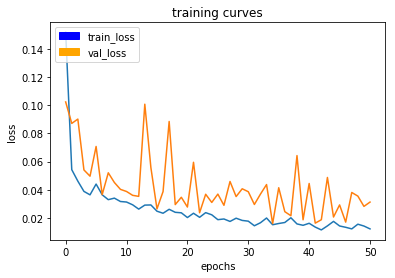

200/200 [==============================] - 95s - loss: 0.0122 - val_loss: 0.0312
Epoch 52/60
199/200 [============================>.] - ETA: 0s - loss: 0.0117

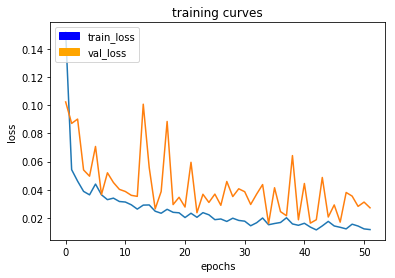

200/200 [==============================] - 95s - loss: 0.0117 - val_loss: 0.0271
Epoch 53/60
199/200 [============================>.] - ETA: 0s - loss: 0.0118

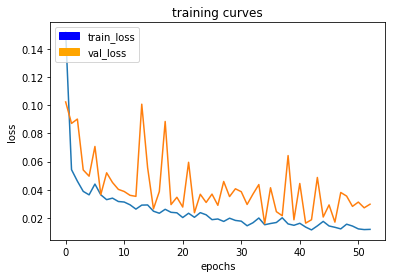

200/200 [==============================] - 94s - loss: 0.0118 - val_loss: 0.0297
Epoch 54/60
199/200 [============================>.] - ETA: 0s - loss: 0.0151

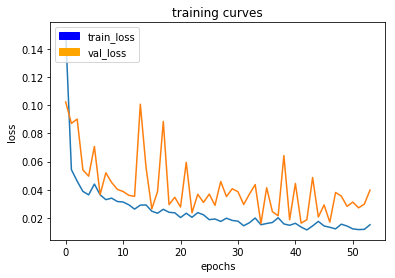

200/200 [==============================] - 94s - loss: 0.0151 - val_loss: 0.0397
Epoch 55/60
199/200 [============================>.] - ETA: 0s - loss: 0.0127

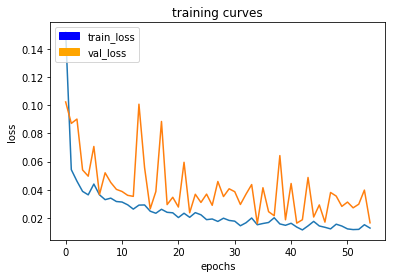

200/200 [==============================] - 96s - loss: 0.0127 - val_loss: 0.0165
Epoch 56/60
199/200 [============================>.] - ETA: 0s - loss: 0.0104

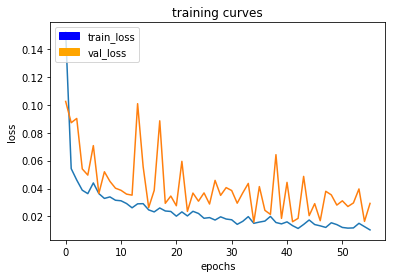

200/200 [==============================] - 95s - loss: 0.0104 - val_loss: 0.0294
Epoch 57/60
199/200 [============================>.] - ETA: 0s - loss: 0.0109

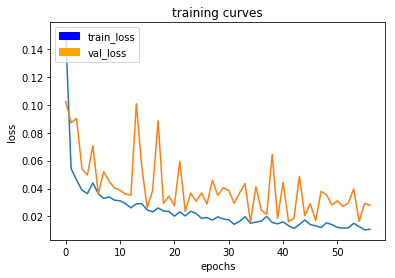

200/200 [==============================] - 95s - loss: 0.0109 - val_loss: 0.0280
Epoch 58/60
199/200 [============================>.] - ETA: 0s - loss: 0.0102

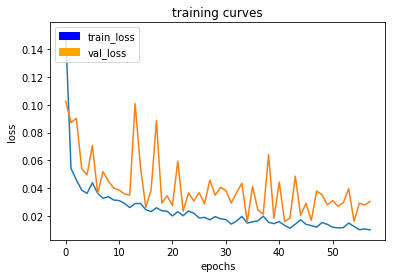

200/200 [==============================] - 95s - loss: 0.0102 - val_loss: 0.0306
Epoch 59/60
199/200 [============================>.] - ETA: 0s - loss: 0.0112

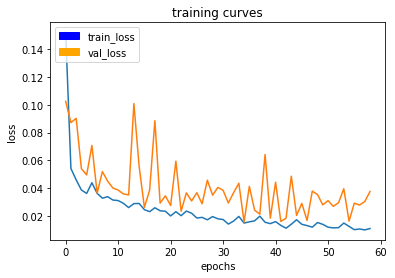

200/200 [==============================] - 95s - loss: 0.0112 - val_loss: 0.0378
Epoch 60/60
199/200 [============================>.] - ETA: 0s - loss: 0.0132

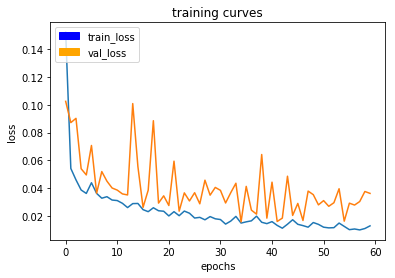

200/200 [==============================] - 95s - loss: 0.0131 - val_loss: 0.0364


In [9]:
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [11]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction 

- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [13]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

In [22]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('evaluation','followme_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

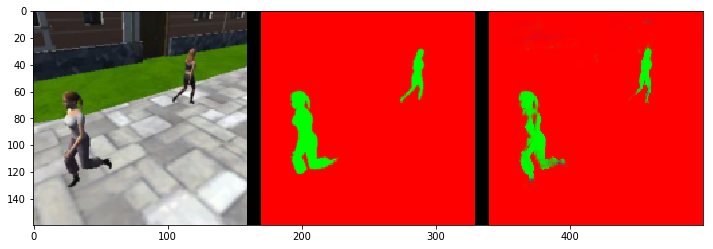

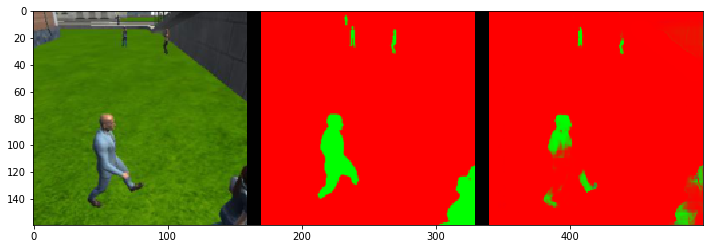

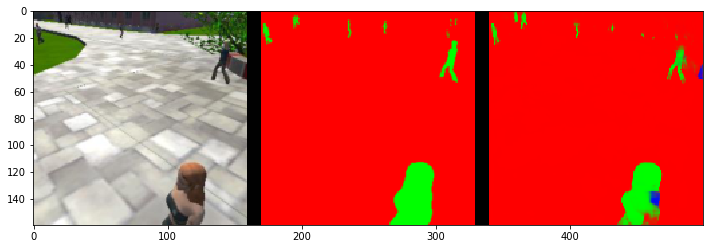

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('evaluation','non_target_patrol', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

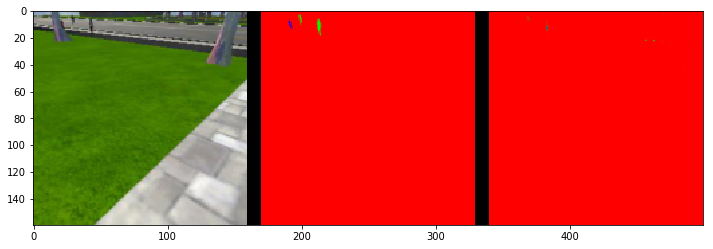

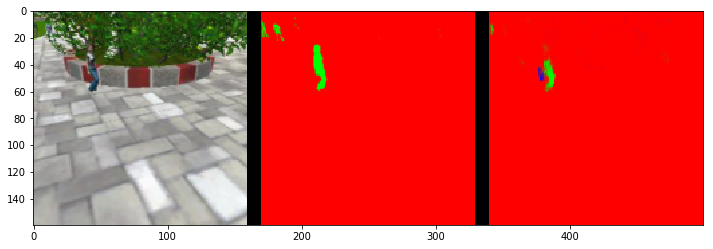

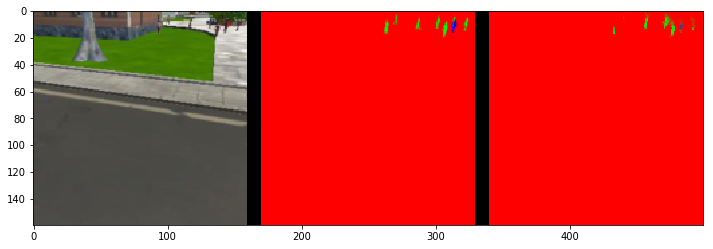

In [15]:
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('evaluation','target_patrol', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9959393761198658
average intersection over union for other people is 0.37246626583063
average intersection over union for the hero is 0.921837679407892
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9868198810085548
average intersection over union for other people is 0.6854561496349869
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 137, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9969404570529306
average intersection over union for other people is 0.46322551130329315
average intersection over union for the hero is 0.27415983134659394
number true positives: 143, number false positives: 5, number false negatives: 158


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.6945010183299389


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.597998755377


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.41531074457
